In [2]:
import pandas as pd

# Read the uploaded CSV
df = pd.read_csv('/content/Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20250526.csv')

# Convert Date to datetime format
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Sort by date and set Date as index
df.sort_values('Date', inplace=True)
df.set_index('Date', inplace=True)

# Fill missing values in 'Other' column
df['Other'] = df['Other'].fillna(0)

# View the data
df.head()


,Local Route,Light Rail,Peak Service,Rapid Route,School,Other
Date,,,,,,
2019-07-01,15987,9962,407,21223,3715,0.0
2019-07-02,16895,10656,409,21715,3993,0.0
2019-07-03,16613,10658,427,22025,3638,0.0
2019-07-04,16604,10445,437,21868,3576,0.0
2019-07-05,16040,10532,400,20697,2856,0.0


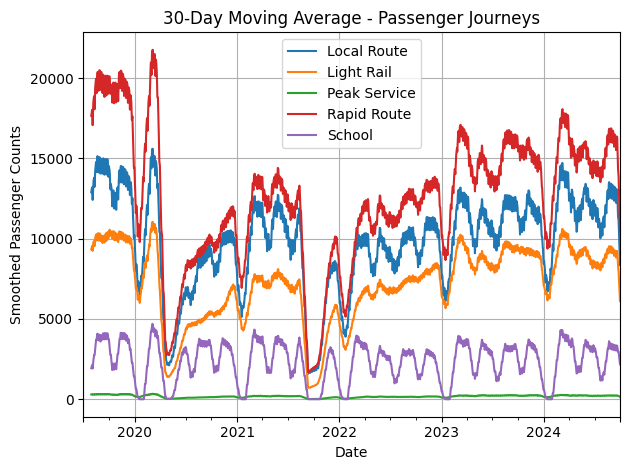

In [3]:
import matplotlib.pyplot as plt

df_rolling = df[['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School']].rolling(window=30).mean()

df_rolling.plot(title="30-Day Moving Average - Passenger Journeys")
plt.ylabel("Smoothed Passenger Counts")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()


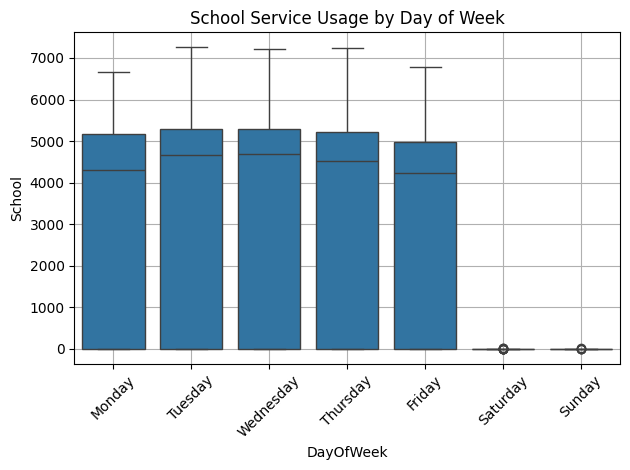

In [4]:
import seaborn as sns

# Extract day of week
df['DayOfWeek'] = df.index.day_name()

# School usage by day of week
sns.boxplot(data=df, x='DayOfWeek', y='School', order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.title("School Service Usage by Day of Week")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


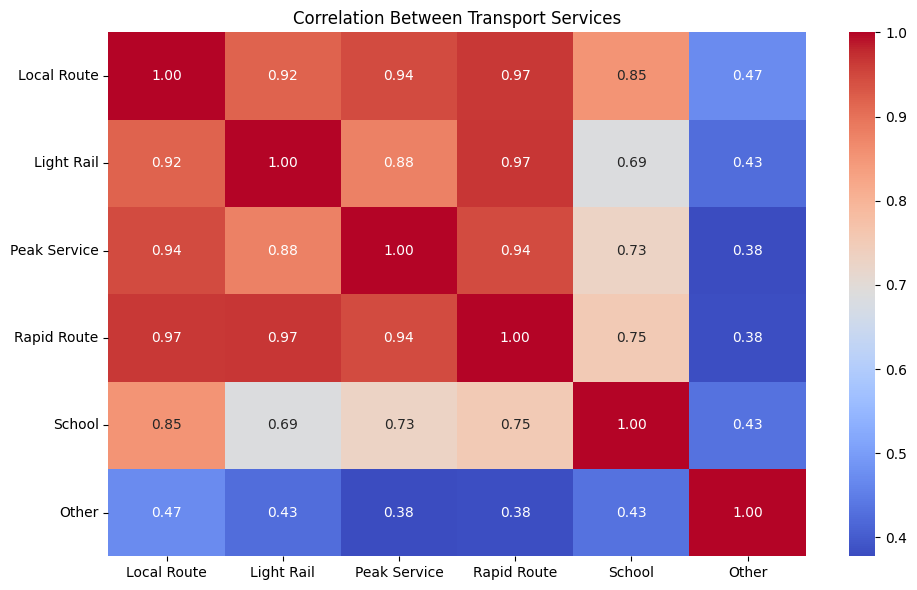

In [5]:
import seaborn as sns

# Select only numeric columns for correlation calculation
numeric_df = df.select_dtypes(include=['number'])

plt.figure(figsize=(10, 6))
# Calculate correlation on the DataFrame with only numeric columns
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Between Transport Services")
plt.tight_layout()
plt.show()

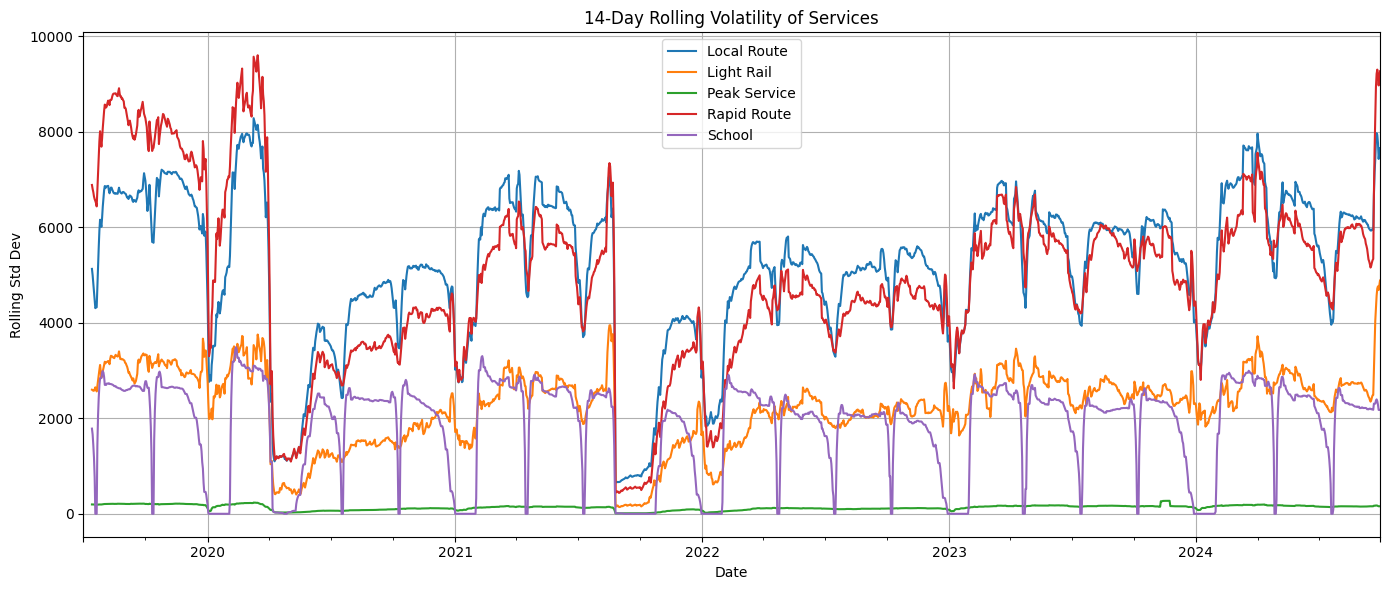

In [6]:
# Day-to-day percent change (volatility)
df_pct_change = df[['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School']].pct_change().dropna()

# 14-day rolling standard deviation (volatility clusters)
rolling_std = df[['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School']].rolling(window=14).std()

# Plotting volatility
rolling_std.plot(title="14-Day Rolling Volatility of Services", figsize=(14,6))
plt.ylabel("Rolling Std Dev")
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
from statsmodels.tsa.stattools import adfuller

# Run ADF test to check for stationarity (trend shifts)
for col in ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School']:
    result = adfuller(df[col].dropna())
    print(f"{col}: ADF Statistic = {result[0]:.4f}, p-value = {result[1]:.4f}")


Local Route: ADF Statistic = -4.5800, p-value = 0.0001
Light Rail: ADF Statistic = -3.4961, p-value = 0.0081
Peak Service: ADF Statistic = -3.8707, p-value = 0.0023
Rapid Route: ADF Statistic = -3.8281, p-value = 0.0026
School: ADF Statistic = -7.1339, p-value = 0.0000


In [8]:
from scipy.stats import zscore
import numpy as np
# Compute z-scores
z_scores = df[['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School']].apply(zscore)

# Flag outliers
anomalies = (np.abs(z_scores) > 3)

# Count anomalies per service
anomalies.sum().sort_values(ascending=False)


,0
Peak Service,1
Local Route,0
Light Rail,0
Rapid Route,0
School,0


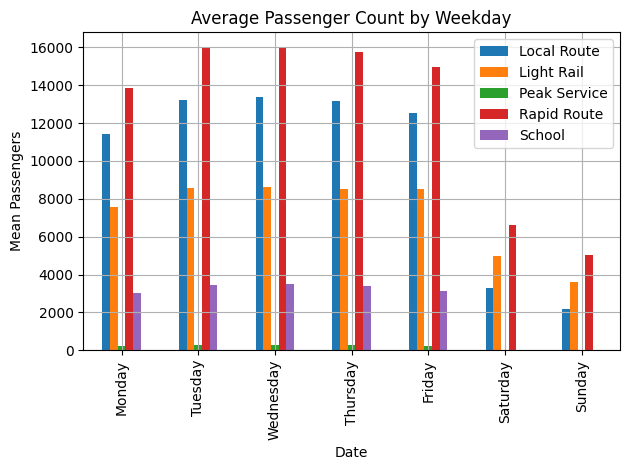

In [9]:
# Average usage per weekday
# Select the numeric columns before applying the mean aggregation
weekday_patterns = df[['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School']].groupby(df.index.day_name()).mean()

# Plot
weekday_patterns.loc[["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]].plot(kind='bar')
plt.title("Average Passenger Count by Weekday")
plt.ylabel("Mean Passengers")
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# The original df is already loaded and preprocessed based on the previous cells.
# It has Date as index and columns for each service type.

def create_features(series, label=None):
    """
    Create time-based features for ML models from a pandas Series.
    """
    # Create a DataFrame from the Series, using the index as the date column
    df_features = series.to_frame(name='ridership_count')
    df_features['date'] = df_features.index

    df_features['dayofweek'] = df_features['date'].dt.dayofweek
    df_features['quarter'] = df_features['date'].dt.quarter
    df_features['month'] = df_features['date'].dt.month
    df_features['year'] = df_features['date'].dt.year
    df_features['dayofyear'] = df_features['date'].dt.dayofyear
    df_features['dayofmonth'] = df_features['date'].dt.day

    # Lag features on the 'ridership_count' column
    df_features['lag_1'] = df_features['ridership_count'].shift(1)
    df_features['lag_7'] = df_features['ridership_count'].shift(7)
    df_features['rolling_mean_7'] = df_features['ridership_count'].shift(1).rolling(window=7).mean()

    # Drop rows with NaN values created by shifting/rolling operations
    df_features = df_features.dropna()

    X = df_features[['dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'lag_1', 'lag_7', 'rolling_mean_7']]
    if label:
        y = df_features[label]
        return X, y
    return X

results = {}

# Iterate directly over the service type columns in the original df
for route_col in ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School']:

    # Select the specific service column as a pandas Series
    df_route_series = df[route_col].copy()

    # ----- Prophet -----
    # Prophet requires columns named 'ds' (date) and 'y' (value)
    prophet_df = df_route_series.reset_index().rename(columns={'Date':'ds', route_col:'y'})[['ds','y']]
    model_prophet = Prophet(daily_seasonality=True)
    model_prophet.fit(prophet_df)
    future = model_prophet.make_future_dataframe(periods=7)
    forecast = model_prophet.predict(future)
    # Use the date index from the original df for the last 7 days for alignment
    prophet_pred = forecast[['ds','yhat']].tail(7).set_index('ds')

    # ----- Prepare data for ML -----
    # Use the create_features function on the selected Series
    X, y = create_features(df_route_series, label='ridership_count')

    # Ensure X and y have the same index for the split
    X = X.loc[y.index]

    # Train/test split - keep last 7 days for test
    X_train, X_test = X[:-7], X[-7:]
    y_train, y_test = y[:-7], y[-7:]

    # ----- Random Forest -----
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_test)

    # ----- XGBoost -----
    xgb = XGBRegressor(n_estimators=100, random_state=42)
    xgb.fit(X_train, y_train)
    xgb_pred = xgb.predict(X_test)

    # Store results with MAE
    results[route_col] = {
        'prophet_forecast': prophet_pred['yhat'],
        'rf_forecast': pd.Series(rf_pred, index=X_test.index), # Ensure predictions have the correct index
        'xgb_forecast': pd.Series(xgb_pred, index=X_test.index), # Ensure predictions have the correct index
        'actual': y_test,
        'mae_prophet': mean_absolute_error(y_test, prophet_pred['yhat']),
        'mae_rf': mean_absolute_error(y_test, rf_pred),
        'mae_xgb': mean_absolute_error(y_test, xgb_pred),
    }

# Print MAE results
for route, res in results.items():
    print(f"Route: {route}")
    print(f"Prophet MAE: {res['mae_prophet']:.2f}")
    print(f"Random Forest MAE: {res['mae_rf']:.2f}")
    print(f"XGBoost MAE: {res['mae_xgb']:.2f}")
    print()

DEBUG:cmdstanpy:input tempfile: /tmp/tmpjjkjgbe8/20oqlqwa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjjkjgbe8/d7876ces.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59149', 'data', 'file=/tmp/tmpjjkjgbe8/20oqlqwa.json', 'init=/tmp/tmpjjkjgbe8/d7876ces.json', 'output', 'file=/tmp/tmpjjkjgbe8/prophet_modelndsg0mkp/prophet_model-20250526054758.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:47:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:47:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjjkjgbe8/61luds66.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjjkjgbe8/i_iy50xc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Route: Local Route
Prophet MAE: 9185.98
Random Forest MAE: 3139.10
XGBoost MAE: 1383.76

Route: Light Rail
Prophet MAE: 7019.50
Random Forest MAE: 3328.36
XGBoost MAE: 2260.65

Route: Peak Service
Prophet MAE: 173.86
Random Forest MAE: 135.93
XGBoost MAE: 136.64

Route: Rapid Route
Prophet MAE: 12373.34
Random Forest MAE: 4591.13
XGBoost MAE: 5696.15

Route: School
Prophet MAE: 1613.18
Random Forest MAE: 544.85
XGBoost MAE: 609.09



Route: Local Route
Prophet MAE: 9185.98
Random Forest MAE: 3139.10
XGBoost MAE: 1383.76



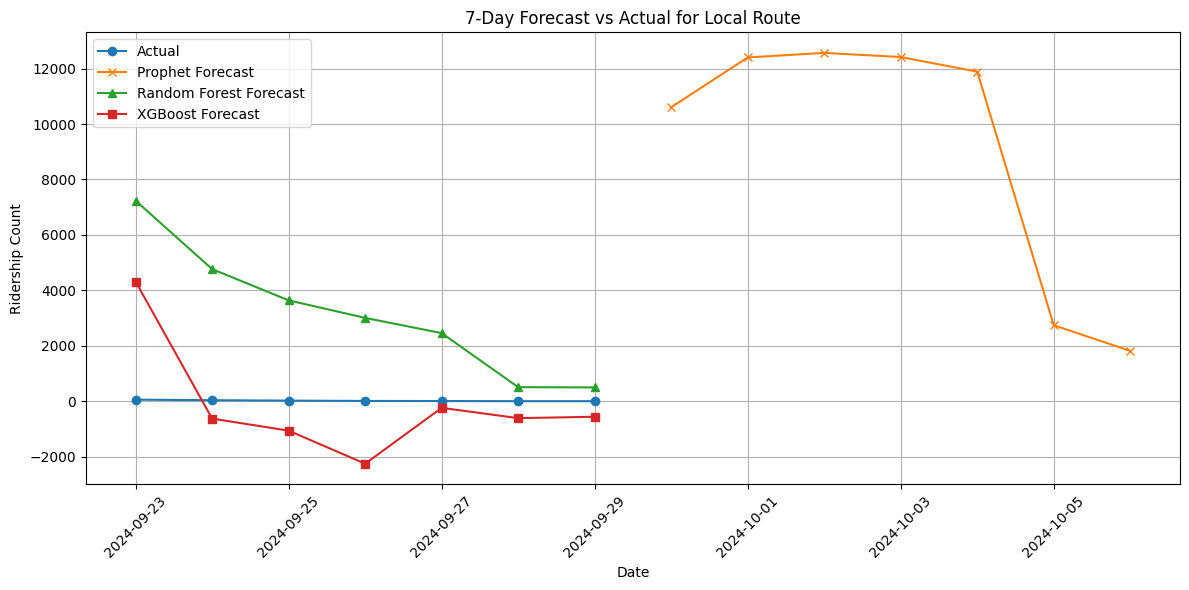

Route: Light Rail
Prophet MAE: 7019.50
Random Forest MAE: 3328.36
XGBoost MAE: 2260.65



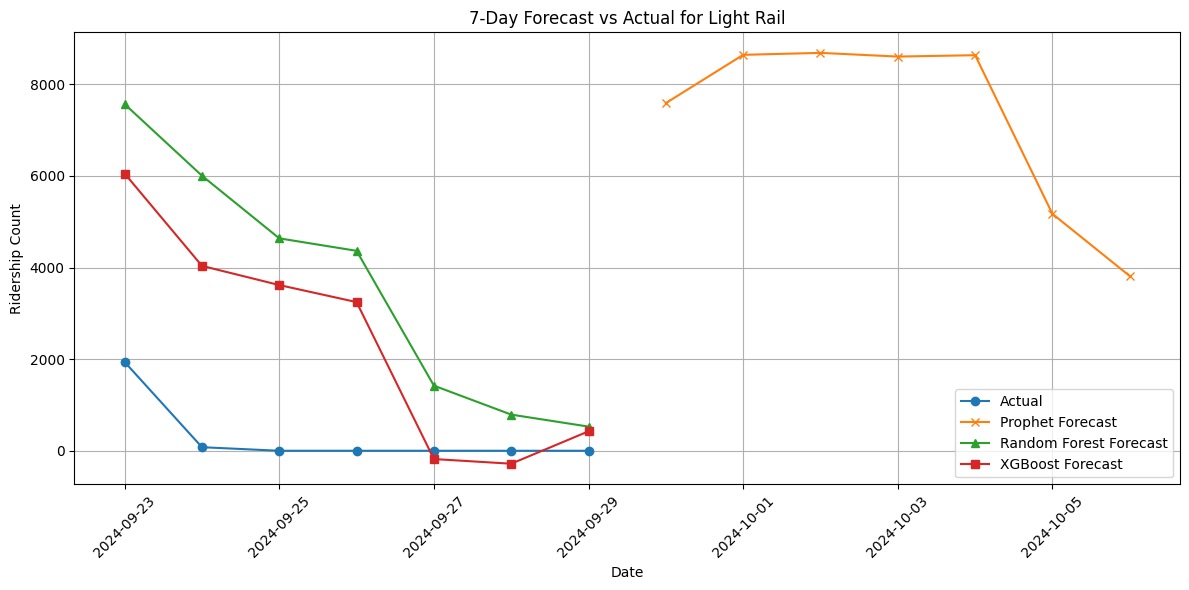

Route: Peak Service
Prophet MAE: 173.86
Random Forest MAE: 135.93
XGBoost MAE: 136.64



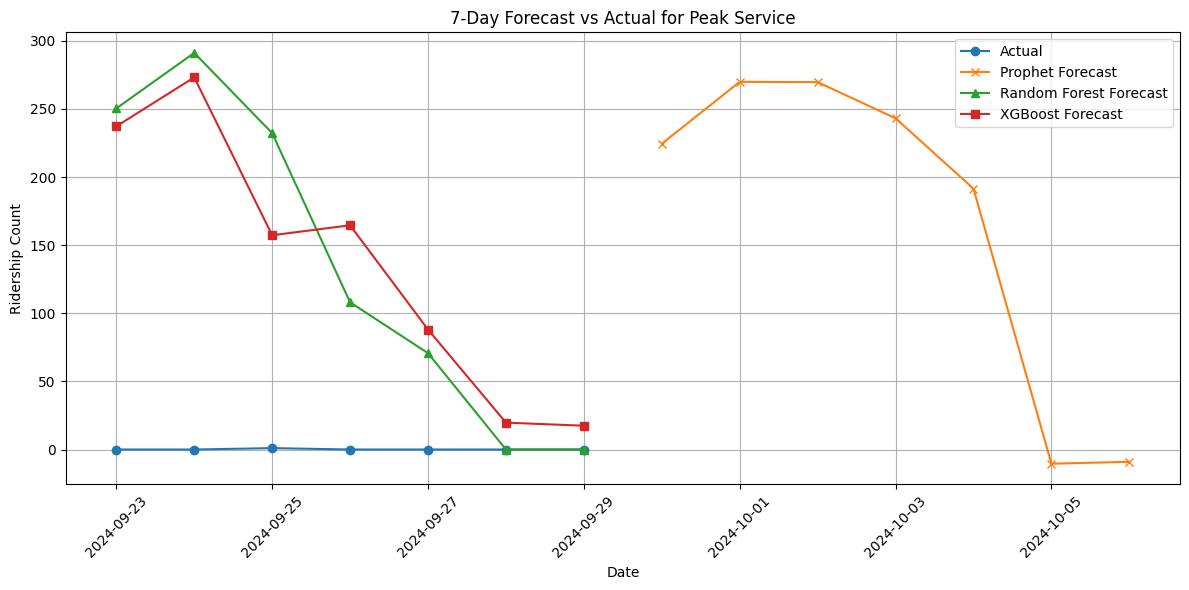

Route: Rapid Route
Prophet MAE: 12373.34
Random Forest MAE: 4591.13
XGBoost MAE: 5696.15



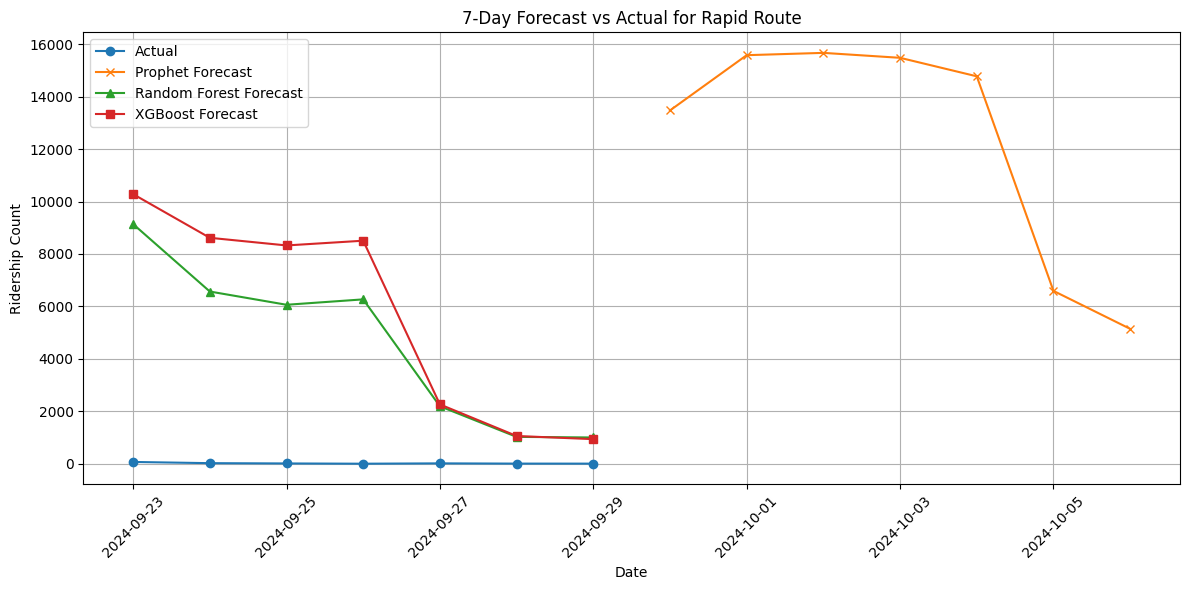

Route: School
Prophet MAE: 1613.18
Random Forest MAE: 544.85
XGBoost MAE: 609.09



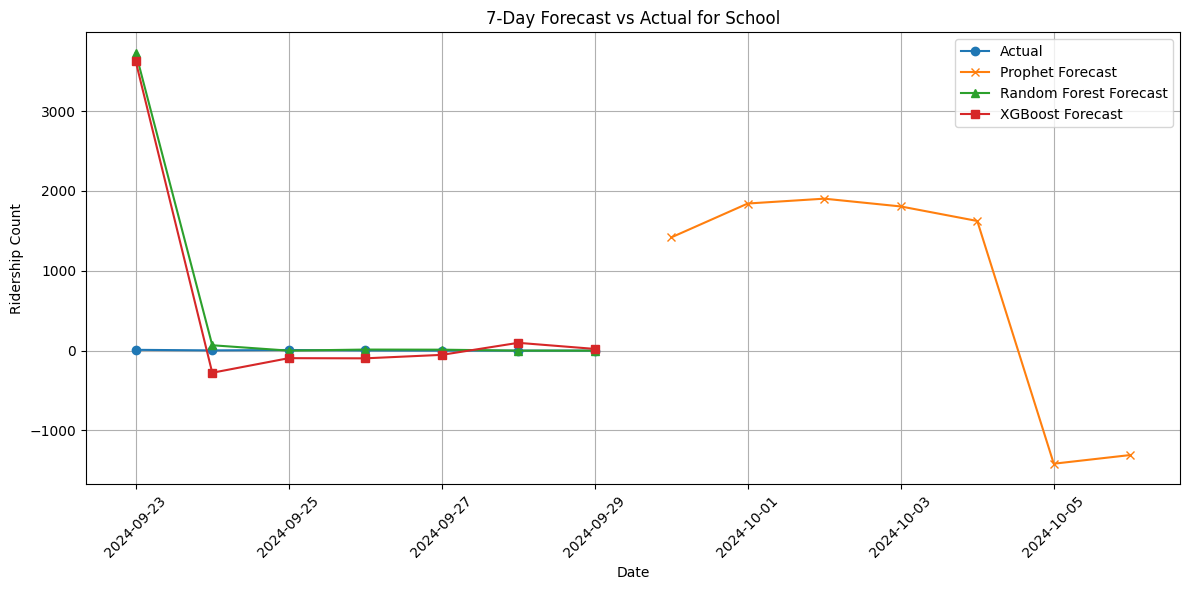

In [23]:
import matplotlib.pyplot as plt

for route, res in results.items():
    print(f"Route: {route}")
    print(f"Prophet MAE: {res['mae_prophet']:.2f}")
    print(f"Random Forest MAE: {res['mae_rf']:.2f}")
    print(f"XGBoost MAE: {res['mae_xgb']:.2f}")
    print()

    plt.figure(figsize=(12, 6))
    plt.plot(res['actual'].index, res['actual'], label='Actual', marker='o')
    plt.plot(res['prophet_forecast'].index, res['prophet_forecast'], label='Prophet Forecast', marker='x')
    plt.plot(res['rf_forecast'].index, res['rf_forecast'], label='Random Forest Forecast', marker='^')
    plt.plot(res['xgb_forecast'].index, res['xgb_forecast'], label='XGBoost Forecast', marker='s')

    plt.title(f"7-Day Forecast vs Actual for {route}")
    plt.xlabel("Date")
    plt.ylabel("Ridership Count")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [17]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import numpy as np

# Random Forest hyperparameter grid
rf_param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# XGBoost hyperparameter grid
xgb_param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

# Random Forest tuning
rf = RandomForestRegressor(random_state=42)
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=rf_param_grid,
                               n_iter=20, cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)
print(f"Best RF params: {rf_random.best_params_}")

# XGBoost tuning
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_random = RandomizedSearchCV(estimator=xgb, param_distributions=xgb_param_grid,
                                n_iter=20, cv=3, verbose=2, random_state=42, n_jobs=-1)
xgb_random.fit(X_train, y_train)
print(f"Best XGB params: {xgb_random.best_params_}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best RF params: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': None, 'bootstrap': True}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best XGB params: {'subsample': 0.6, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


In [18]:
# Train final RF with best params
best_rf = RandomForestRegressor(**rf_random.best_params_, random_state=42)
best_rf.fit(X_train, y_train)
rf_preds = best_rf.predict(X_test)

# Train final XGB with best params
best_xgb = XGBRegressor(**xgb_random.best_params_, objective='reg:squarederror', random_state=42)
best_xgb.fit(X_train, y_train)
xgb_preds = best_xgb.predict(X_test)

# Evaluate
from sklearn.metrics import mean_absolute_error
print(f"RF MAE: {mean_absolute_error(y_test, rf_preds)}")
print(f"XGB MAE: {mean_absolute_error(y_test, xgb_preds)}")


RF MAE: 541.7468003167465
XGB MAE: 484.5176696777344


Route: Local Route
Prophet MAE: 9185.98
Random Forest MAE: 3139.10
XGBoost MAE: 1383.76



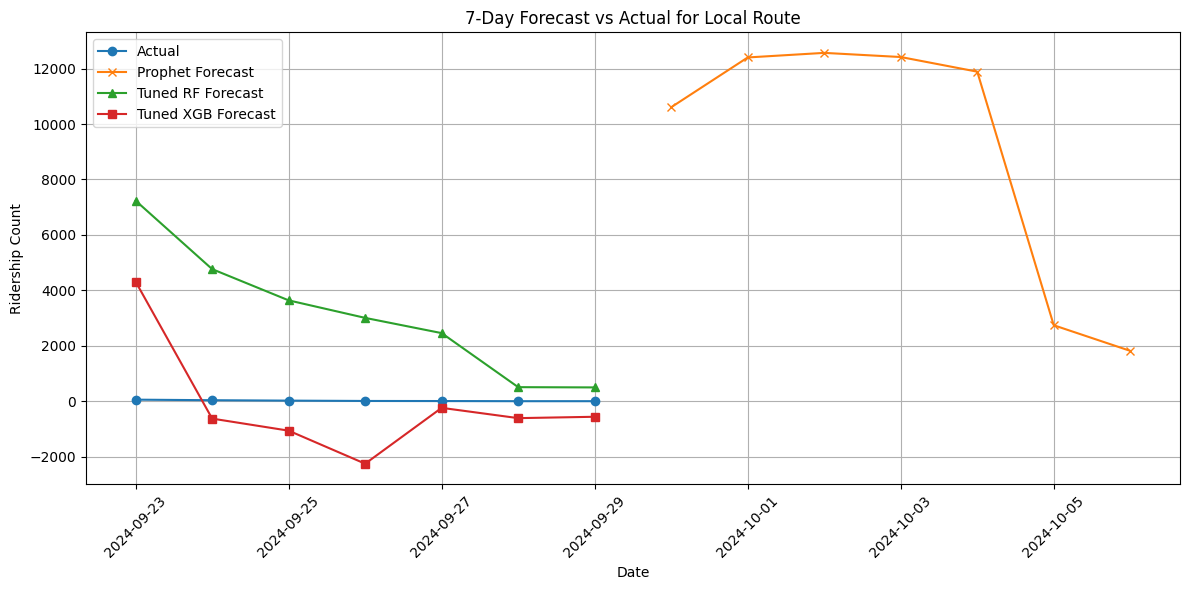

Route: Light Rail
Prophet MAE: 7019.50
Random Forest MAE: 3328.36
XGBoost MAE: 2260.65



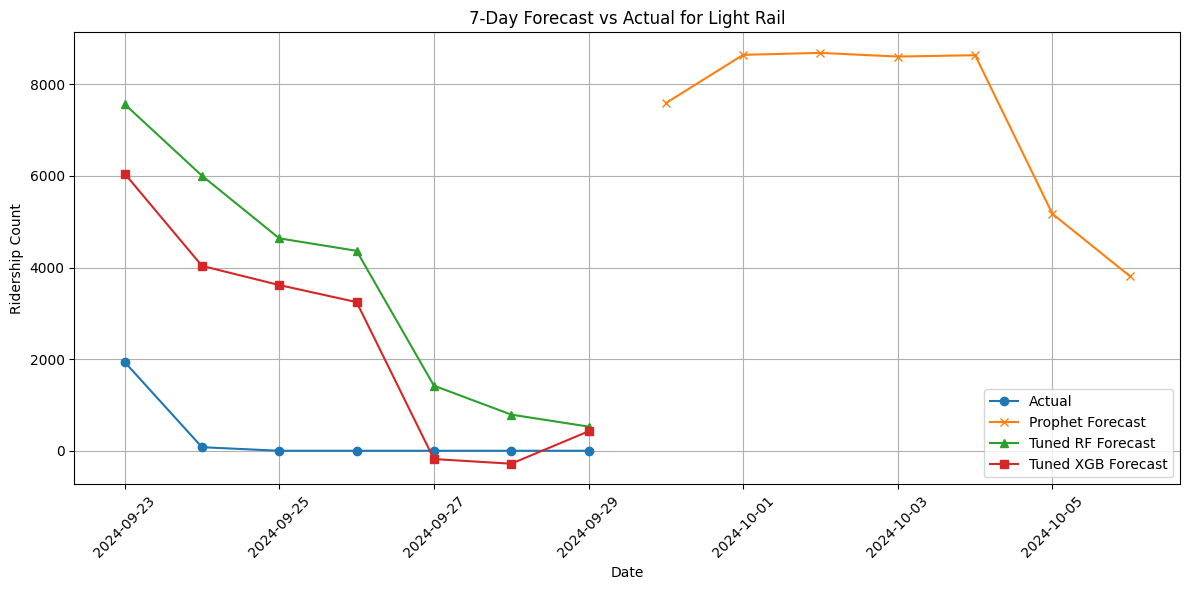

Route: Peak Service
Prophet MAE: 173.86
Random Forest MAE: 135.93
XGBoost MAE: 136.64



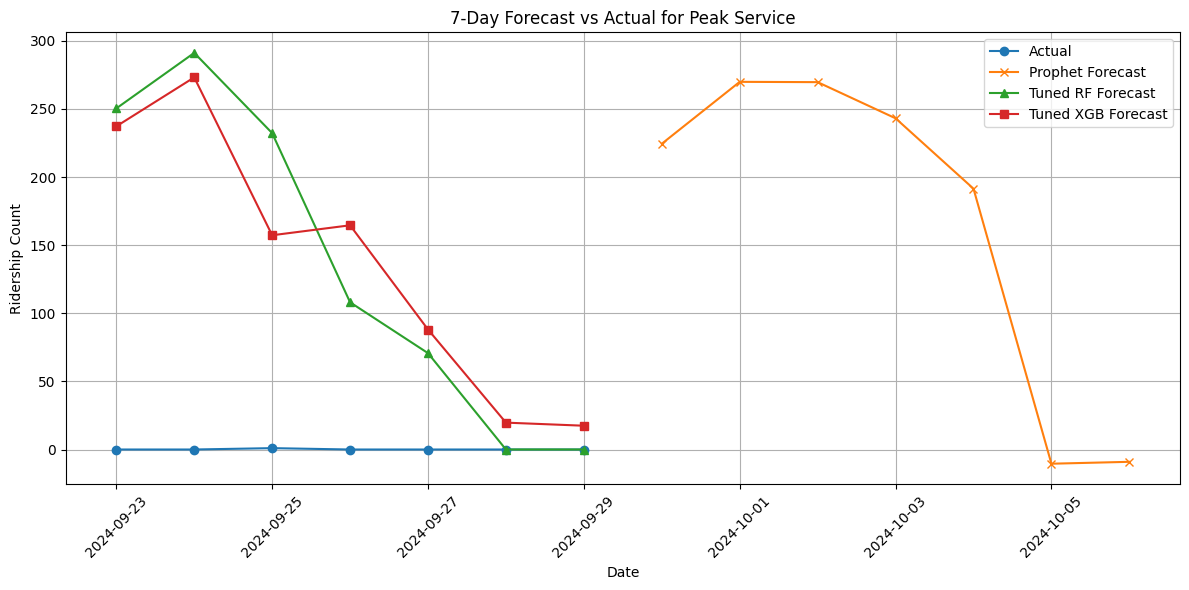

Route: Rapid Route
Prophet MAE: 12373.34
Random Forest MAE: 4591.13
XGBoost MAE: 5696.15



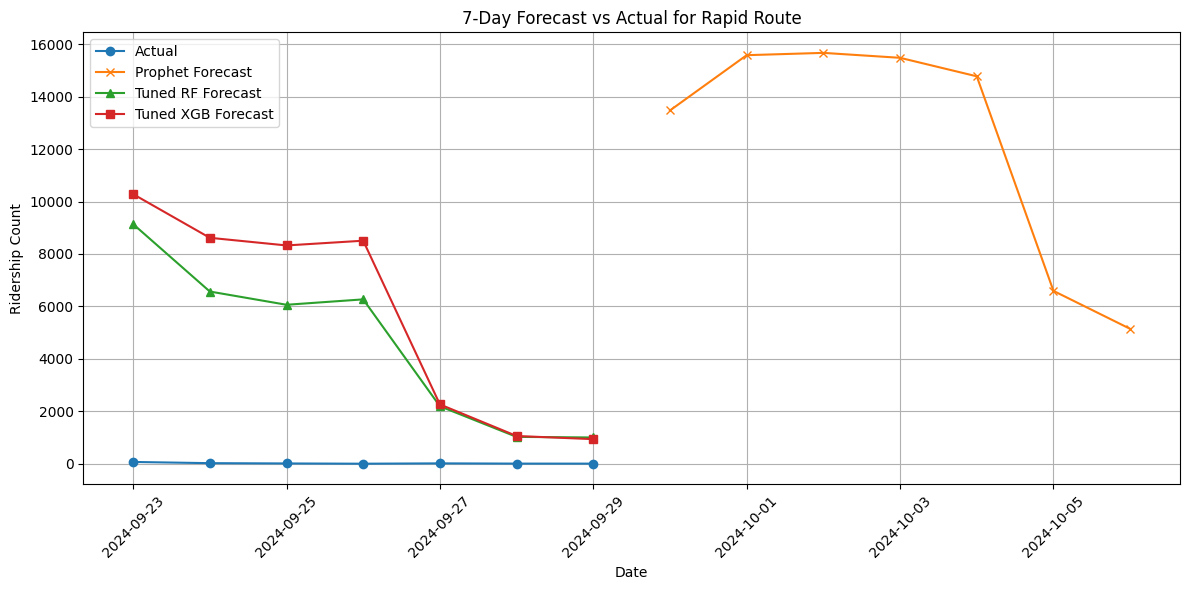

Route: School
Prophet MAE: 1613.18
Random Forest MAE: 541.75
XGBoost MAE: 484.52



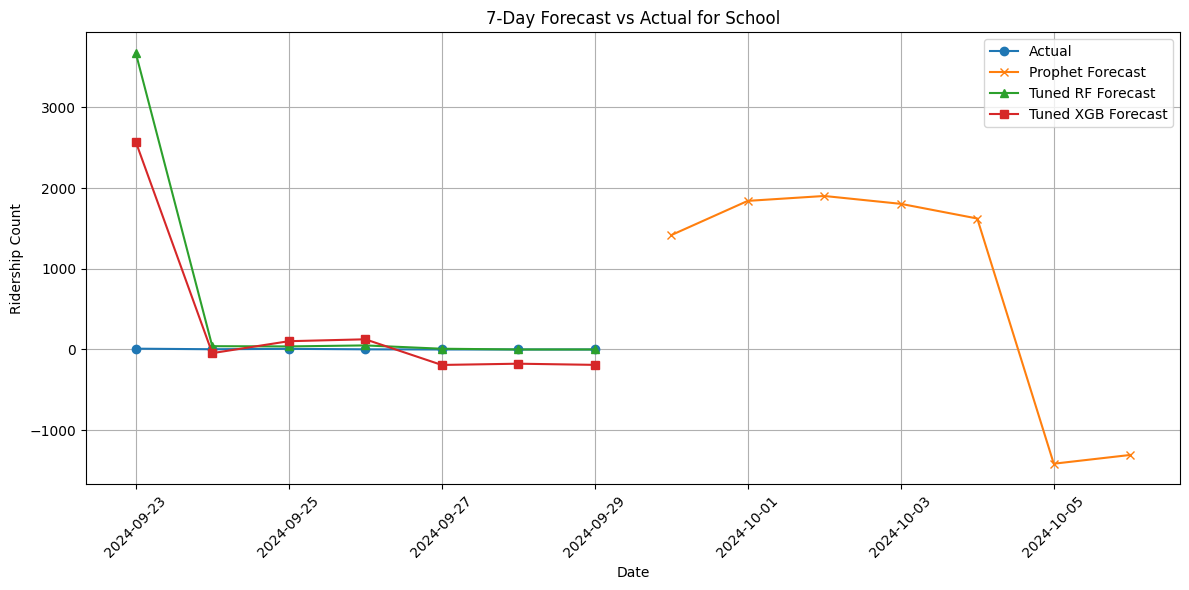

In [24]:
import matplotlib.pyplot as plt

# Replace this part inside your main loop after the X_train/y_train split:
# Assuming you're looping over each route already

# Train final RF with best params
best_rf = RandomForestRegressor(**rf_random.best_params_, random_state=42)
best_rf.fit(X_train, y_train)
rf_preds = best_rf.predict(X_test)

# Train final XGB with best params
best_xgb = XGBRegressor(**xgb_random.best_params_, objective='reg:squarederror', random_state=42)
best_xgb.fit(X_train, y_train)
xgb_preds = best_xgb.predict(X_test)

# Store and plot
results[route_col] = {
    'prophet_forecast': prophet_pred['yhat'],
    'rf_forecast': pd.Series(rf_preds, index=X_test.index),
    'xgb_forecast': pd.Series(xgb_preds, index=X_test.index),
    'actual': y_test,
    'mae_prophet': mean_absolute_error(y_test, prophet_pred['yhat']),
    'mae_rf': mean_absolute_error(y_test, rf_preds),
    'mae_xgb': mean_absolute_error(y_test, xgb_preds),
}

# Plotting section (same as before)
for route, res in results.items():
    print(f"Route: {route}")
    print(f"Prophet MAE: {res['mae_prophet']:.2f}")
    print(f"Random Forest MAE: {res['mae_rf']:.2f}")
    print(f"XGBoost MAE: {res['mae_xgb']:.2f}")
    print()

    plt.figure(figsize=(12, 6))
    plt.plot(res['actual'].index, res['actual'], label='Actual', marker='o')
    plt.plot(res['prophet_forecast'].index, res['prophet_forecast'], label='Prophet Forecast', marker='x')
    plt.plot(res['rf_forecast'].index, res['rf_forecast'], label='Tuned RF Forecast', marker='^')
    plt.plot(res['xgb_forecast'].index, res['xgb_forecast'], label='Tuned XGB Forecast', marker='s')

    plt.title(f"7-Day Forecast vs Actual for {route}")
    plt.xlabel("Date")
    plt.ylabel("Ridership Count")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
